In [1]:
import numpy as np

C:\Users\aliye\Anaconda3\lib\site-packages\scikit-image-master\skimage\feature\_hog.py:149: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To suppress this message specify explicitly the normalization method.
  skimage_deprecation)


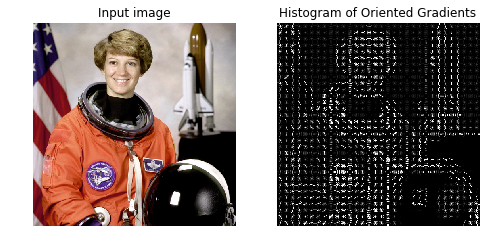

In [2]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [3]:
fd.shape

(8192,)

In [4]:
image.shape

(512, 512, 3)

In [16]:
def _hog_channel_gradient(channel):
    """Compute unnormalized gradient image along `row` and `col` axes.
    Parameters
    ----------
    channel : (M, N) ndarray
        Grayscale image or one of image channel.
    Returns
    -------
    g_row, g_col : channel gradient along `row` and `col` axes correspondingly.
    """
    g_row = np.empty(channel.shape, dtype=np.double)
    g_row[0, :] = 0
    g_row[-1, :] = 0
    g_row[1:-1, :] = channel[2:, :] - channel[:-2, :]
    g_col = np.empty(channel.shape, dtype=np.double)
    g_col[:, 0] = 0
    g_col[:, -1] = 0
    g_col[:, 1:-1] = channel[:, 2:] - channel[:, :-2]

    return g_row, g_col

In [25]:
def hog_histograms(gradient_columns,
                   gradient_rows,cell_columns, cell_rows,size_columns, size_rows, number_of_cells_columns,  number_of_cells_rows, number_of_orientations):
    """Extract Histogram of Oriented Gradients (HOG) for a given image.
    Parameters
    ----------
    gradient_columns : ndarray
        First order image gradients (rows).
    gradient_rows : ndarray
        First order image gradients (columns).
    cell_columns : int
        Pixels per cell (rows).
    cell_rows : int
        Pixels per cell (columns).
    size_columns : int
        Number of columns.
    size_rows : int
        Number of rows.
    number_of_cells_columns : int
        Number of cells (rows).
    number_of_cells_rows : int
        Number of cells (columns).
    number_of_orientations : int
        Number of orientation bins.
    orientation_histogram : ndarray
        The histogram array which is modified in place.
    """

    magnitude = np.hypot(gradient_columns,
                                             gradient_rows)
    orientation = \
        np.rad2deg(np.arctan2(gradient_rows, gradient_columns)) % 180
    
    
    orientation_histogram = np.zeros((number_of_cells_columns, number_of_cells_columns, number_of_orientations))

    r_0 = cell_rows // 2
    c_0 = cell_columns // 2
    cc = cell_rows * number_of_cells_rows
    cr = cell_columns * number_of_cells_columns
    range_rows_stop = cell_rows // 2
    range_rows_start = -range_rows_stop
    range_columns_stop = cell_columns / 2
    range_columns_start = -range_columns_stop
    number_of_orientations_per_180 = 180. / number_of_orientations
    
    # compute orientations integral images
    for i in range(number_of_orientations):
        # isolate orientations in this range
        orientation_start = number_of_orientations_per_180 * (i + 1)
        orientation_end = number_of_orientations_per_180 * i
        c = c_0
        r = r_0
        r_i = 0
        c_i = 0

        while r < cc:
            c_i = 0
            c = c_0

            while c < cr:
                orientation_histogram[r_i, c_i, i] = \
                    cell_hog(magnitude, orientation,
                             orientation_start, orientation_end,
                             cell_columns, cell_rows, c, r,
                             size_columns, size_rows,
                             range_rows_start, range_rows_stop,
                             range_columns_start, range_columns_stop)
                c_i += 1
                c += cell_columns

            r_i += 1
            r += cell_rows
    return orientation_histogram

def cell_hog(magnitude,orientation,orientation_start, orientation_end,cell_columns, cell_rows,column_index,  
             row_index,size_columns, size_rows,range_rows_start, range_rows_stop,range_columns_start, range_columns_stop):
    """Calculation of the cell's HOG value
    Parameters
    ----------
    magnitude : ndarray
        The gradient magnitudes of the pixels.
    orientation : ndarray
        Lookup table for orientations.
    orientation_start : float
        Orientation range start.
    orientation_end : float
        Orientation range end.
    cell_columns : int
        Pixels per cell (rows).
    cell_rows : int
        Pixels per cell (columns).
    column_index : int
        Block column index.
    row_index : int
        Block row index.
    size_columns : int
        Number of columns.
    size_rows : int
        Number of rows.
    range_rows_start : int
        Start row of cell.
    range_rows_stop : int
        Stop row of cell.
    range_columns_start : int
        Start column of cell.
    range_columns_stop : int
        Stop column of cell
    Returns
    -------
    total : float
        The total HOG value.
    """
#     cdef int cell_column, cell_row, cell_row_index, cell_column_index
    total = 0.
    print(range_rows_start)
    print(range_rows_stop)
    print(range(range_rows_start, range_rows_stop))
    for cell_row in range(range_rows_start, range_rows_stop):
        cell_row_index = row_index + cell_row
        if (cell_row_index < 0 or cell_row_index >= size_rows):
            continue

        for cell_column in range(range_columns_start, range_columns_stop):
            cell_column_index = column_index + cell_column
            if (cell_column_index < 0 or cell_column_index >= size_columns
                    or orientation[cell_row_index, cell_column_index]
                    >= orientation_start
                    or orientation[cell_row_index, cell_column_index]
                    < orientation_end):
                continue

            total += magnitude[cell_row_index, cell_column_index]

    return total / (cell_rows * cell_columns)

In [26]:
def gradient(image,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1)):

        # convert uint image to float
        # to avoid problems with subtracting unsigned numbers
        image = image.astype('float')

        g_row_by_ch = np.empty_like(image, dtype=np.double)
        g_col_by_ch = np.empty_like(image, dtype=np.double)
        g_magn = np.empty_like(image, dtype=np.double)

        for idx_ch in range(image.shape[2]):
            g_row_by_ch[:, :, idx_ch], g_col_by_ch[:, :, idx_ch] = \
                _hog_channel_gradient(image[:, :, idx_ch])
            g_magn[:, :, idx_ch] = np.hypot(g_row_by_ch[:, :, idx_ch],
                                            g_col_by_ch[:, :, idx_ch])

        # For each pixel select the channel with the highest gradient magnitude
        idcs_max = g_magn.argmax(axis=2)
        rr, cc = np.meshgrid(np.arange(image.shape[0]),
                             np.arange(image.shape[1]),
                             indexing='ij',
                             sparse=True)
        g_row = g_row_by_ch[rr, cc, idcs_max]
        g_col = g_col_by_ch[rr, cc, idcs_max]

        s_row, s_col = image.shape[:2]
        c_row, c_col = pixels_per_cell
        b_row, b_col = cells_per_block

        n_cells_row = int(s_row // c_row)  # number of cells along row-axis
        n_cells_col = int(s_col // c_col)  # number of cells along col-axis

        # compute orientations integral images

        orientation_histogram= hog_histograms(g_col, g_row, c_col, c_row, s_col, s_row,
                                     n_cells_col, n_cells_row,
                                     orientations)
        print(orientation_histogram)

In [27]:
gradient(image)

-8
8
range(-8, 8)


TypeError: 'float' object cannot be interpreted as an integer

In [20]:
for a in range(-8,8):
    print(a)

-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
